<a href="https://colab.research.google.com/github/dc-neo/incidents_sla/blob/main/Incident_Aggregation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Importing some packages I may use

import pandas as pd
import os
from google.colab import files
from google.colab import drive
import numpy as np


# Mounting my drive so I can open the file

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Users who have purchased one of Colab's paid plans have access to premium GPUs. You can upgrade your notebook's GPU settings in Runtime > Change runtime type in the menu to enable Premium accelerator. Subject to availability, selecting a premium GPU may grant you access to a V100 or A100 Nvidia GPU.

In [2]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  gpu_available=False
  print('Not connected to a GPU')
else:
  gpu_available=True
  print(gpu_info)

Sat Oct 14 22:18:43 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0    53W / 400W |      0MiB / 40960MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
# Bringing the file in from my Colab Notebook folder

data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/incident_event_log.csv')
data

,number,incident_state,active,reassignment_count,reopen_count,sys_mod_count,made_sla,caller_id,opened_by,opened_at,...,u_priority_confirmation,notify,problem_id,rfc,vendor,caused_by,closed_code,resolved_by,resolved_at,closed_at
0,INC0000045,New,True,0,0,0,True,Caller 2403,Opened by 8,29/2/2016 01:16,...,False,Do Not Notify,?,?,?,?,code 5,Resolved by 149,29/2/2016 11:29,5/3/2016 12:00
1,INC0000045,Resolved,True,0,0,2,True,Caller 2403,Opened by 8,29/2/2016 01:16,...,False,Do Not Notify,?,?,?,?,code 5,Resolved by 149,29/2/2016 11:29,5/3/2016 12:00
2,INC0000045,Resolved,True,0,0,3,True,Caller 2403,Opened by 8,29/2/2016 01:16,...,False,Do Not Notify,?,?,?,?,code 5,Resolved by 149,29/2/2016 11:29,5/3/2016 12:00
3,INC0000045,Closed,False,0,0,4,True,Caller 2403,Opened by 8,29/2/2016 01:16,...,False,Do Not Notify,?,?,?,?,code 5,Resolved by 149,29/2/2016 11:29,5/3/2016 12:00
4,INC0000047,New,True,0,0,0,True,Caller 2403,Opened by 397,29/2/2016 04:40,...,False,Do Not Notify,?,?,?,?,code 5,Resolved by 81,1/3/2016 09:52,6/3/2016 10:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
141707,INC0120835,Closed,False,1,0,4,True,Caller 116,Opened by 12,16/2/2017 09:09,...,True,Do Not Notify,?,?,?,?,code 9,Resolved by 9,16/2/2017 09:53,16/2/2017 09:53
141708,INC0121064,Active,True,0,0,0,True,Caller 116,Opened by 12,16/2/2017 14:17,...,False,Do Not Notify,?,?,?,?,code 6,Resolved by 9,16/2/2017 16:38,16/2/2017 16:38
141709,INC0121064,Active,True,1,0,1,True,Caller 116,Opened by 12,16/2/2017 14:17,...,False,Do Not Notify,?,?,?,?,code 6,Resolved by 9,16/2/2017 16:38,16/2/2017 16:38
141710,INC0121064,Resolved,True,1,0,2,True,Caller 116,Opened by 12,16/2/2017 14:17,...,True,Do Not Notify,?,?,?,?,code 6,Resolved by 9,16/2/2017 16:38,16/2/2017 16:38


In [4]:
# Creating a copy, just in case I'd like to revisit it

df_original = data.copy()

In [5]:
# Creating a new Dataframe (df) in which we can start transforming the data

df = data.copy()

In [6]:
#!pip install ydata-profiling
#from ydata_profiling import ProfileReport
#import pandas as pd
#pr = ProfileReport(data)
#pr.to_file(output_file="EDA.html")

In [7]:
data.head(5)

,number,incident_state,active,reassignment_count,reopen_count,sys_mod_count,made_sla,caller_id,opened_by,opened_at,...,u_priority_confirmation,notify,problem_id,rfc,vendor,caused_by,closed_code,resolved_by,resolved_at,closed_at
0,INC0000045,New,True,0,0,0,True,Caller 2403,Opened by 8,29/2/2016 01:16,...,False,Do Not Notify,?,?,?,?,code 5,Resolved by 149,29/2/2016 11:29,5/3/2016 12:00
1,INC0000045,Resolved,True,0,0,2,True,Caller 2403,Opened by 8,29/2/2016 01:16,...,False,Do Not Notify,?,?,?,?,code 5,Resolved by 149,29/2/2016 11:29,5/3/2016 12:00
2,INC0000045,Resolved,True,0,0,3,True,Caller 2403,Opened by 8,29/2/2016 01:16,...,False,Do Not Notify,?,?,?,?,code 5,Resolved by 149,29/2/2016 11:29,5/3/2016 12:00
3,INC0000045,Closed,False,0,0,4,True,Caller 2403,Opened by 8,29/2/2016 01:16,...,False,Do Not Notify,?,?,?,?,code 5,Resolved by 149,29/2/2016 11:29,5/3/2016 12:00
4,INC0000047,New,True,0,0,0,True,Caller 2403,Opened by 397,29/2/2016 04:40,...,False,Do Not Notify,?,?,?,?,code 5,Resolved by 81,1/3/2016 09:52,6/3/2016 10:00


In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 141712 entries, 0 to 141711
Data columns (total 36 columns):
 #   Column                   Non-Null Count   Dtype 
---  ------                   --------------   ----- 
 0   number                   141712 non-null  object
 1   incident_state           141712 non-null  object
 2   active                   141712 non-null  bool  
 3   reassignment_count       141712 non-null  int64 
 4   reopen_count             141712 non-null  int64 
 5   sys_mod_count            141712 non-null  int64 
 6   made_sla                 141712 non-null  bool  
 7   caller_id                141712 non-null  object
 8   opened_by                141712 non-null  object
 9   opened_at                141712 non-null  object
 10  sys_created_by           141712 non-null  object
 11  sys_created_at           141712 non-null  object
 12  sys_updated_by           141712 non-null  object
 13  sys_updated_at           141712 non-null  object
 14  contact_type        

In [9]:
data.describe()

,reassignment_count,reopen_count,sys_mod_count
count,141712.000000,141712.000000,141712.000000
mean,1.104197,0.021918,5.080946
std,1.734673,0.207302,7.680652
min,0.000000,0.000000,0.000000
25%,0.000000,0.000000,1.000000
50%,1.000000,0.000000,3.000000
75%,1.000000,0.000000,6.000000
max,27.000000,8.000000,129.000000


In [10]:
data.isnull().sum()

number                     0
incident_state             0
active                     0
reassignment_count         0
reopen_count               0
sys_mod_count              0
made_sla                   0
caller_id                  0
opened_by                  0
opened_at                  0
sys_created_by             0
sys_created_at             0
sys_updated_by             0
sys_updated_at             0
contact_type               0
location                   0
category                   0
subcategory                0
u_symptom                  0
cmdb_ci                    0
impact                     0
urgency                    0
priority                   0
assignment_group           0
assigned_to                0
knowledge                  0
u_priority_confirmation    0
notify                     0
problem_id                 0
rfc                        0
vendor                     0
caused_by                  0
closed_code                0
resolved_by                0
resolved_at   

In [11]:
data[['made_sla']].describe()

,made_sla
count,141712
unique,2
top,True
freq,132497


In [12]:
freq_table = pd.Series(data['made_sla']).value_counts()
print(freq_table)

True     132497
False      9215
Name: made_sla, dtype: int64


In [13]:
import matplotlib.pyplot as plt

DATA EXPLORATION: CATEGORICAL VARIABLES

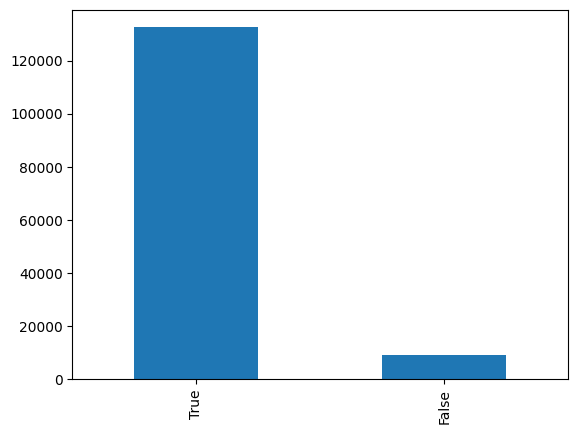

In [14]:
freq_table = pd.Series(data['made_sla']).value_counts()
plt.figure()
freq_table.plot.bar();

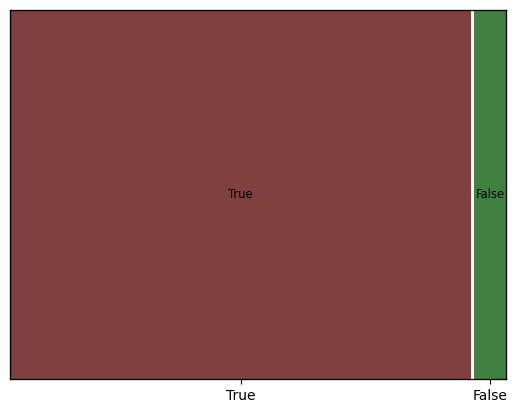

In [15]:
import statsmodels.graphics.mosaicplot as mp
freq_table = pd.Series(data['made_sla']).value_counts()
mp.mosaic(freq_table);

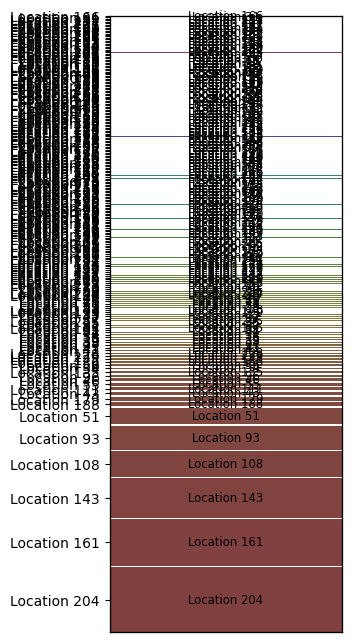

In [16]:
freq_table = pd.Series(data['location']).value_counts()
fig = plt.figure(figsize=(3,8))
ax = fig.add_subplot(111)
mp.mosaic(freq_table, ax=ax, horizontal=0);

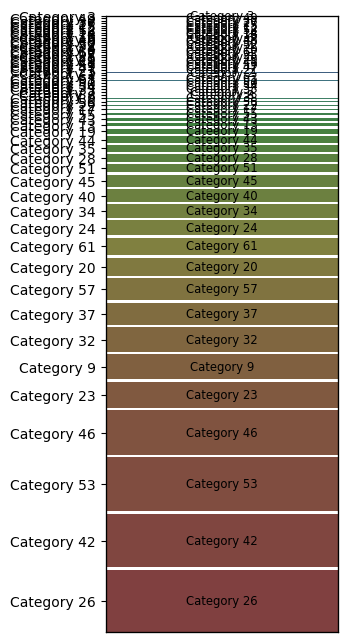

In [17]:
freq_table = pd.Series(data['category']).value_counts()
fig = plt.figure(figsize=(3,8))
ax = fig.add_subplot(111)
mp.mosaic(freq_table, ax=ax, horizontal=0);

<Figure size 640x480 with 0 Axes>

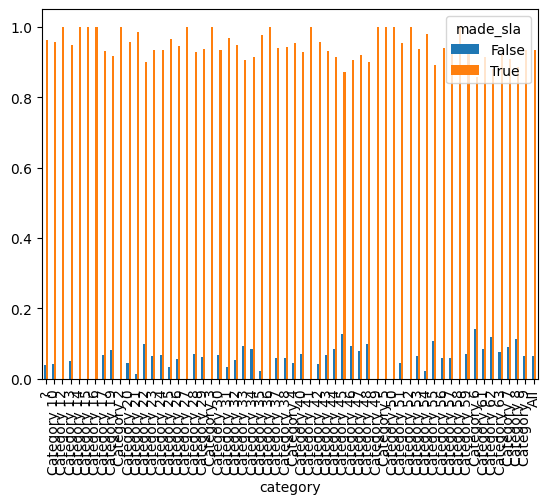

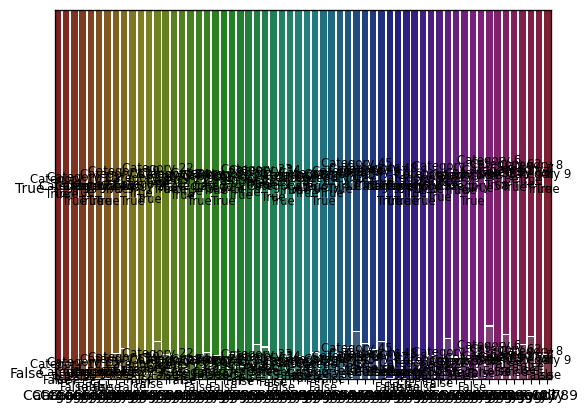

In [18]:
crosstab_1 = pd.crosstab(data.category, data.made_sla, margins=True, normalize='index')
#2. Plot a bar plot
plt.figure()
crosstab_1.plot.bar();

#3. Plot mosacia plot of cross-tab
mp.mosaic(crosstab_1.stack());

<Axes: xlabel='location'>

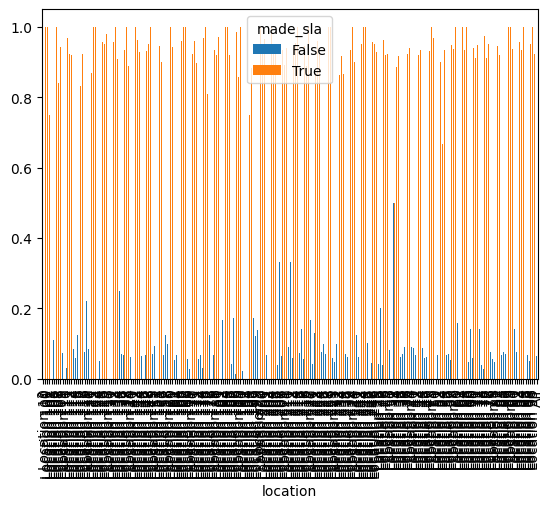

In [19]:
crosstab_2 = pd.crosstab(data.location, data.made_sla, margins=True, normalize='index')
crosstab_2.plot.bar()

DATA EXPLORATION: NUMERIC VARIABLES

In [20]:
data.describe()

,reassignment_count,reopen_count,sys_mod_count
count,141712.000000,141712.000000,141712.000000
mean,1.104197,0.021918,5.080946
std,1.734673,0.207302,7.680652
min,0.000000,0.000000,0.000000
25%,0.000000,0.000000,1.000000
50%,1.000000,0.000000,3.000000
75%,1.000000,0.000000,6.000000
max,27.000000,8.000000,129.000000


In [21]:
x=pd.Series(data['reassignment_count'])
x.head()

0    0
1    0
2    0
3    0
4    0
Name: reassignment_count, dtype: int64

(array([1.22077e+05, 1.54830e+04, 3.00600e+03, 6.50000e+02, 3.43000e+02,
        7.90000e+01, 2.90000e+01, 2.70000e+01, 1.20000e+01, 6.00000e+00]),
 array([ 0. ,  2.7,  5.4,  8.1, 10.8, 13.5, 16.2, 18.9, 21.6, 24.3, 27. ]),
 <BarContainer object of 10 artists>)

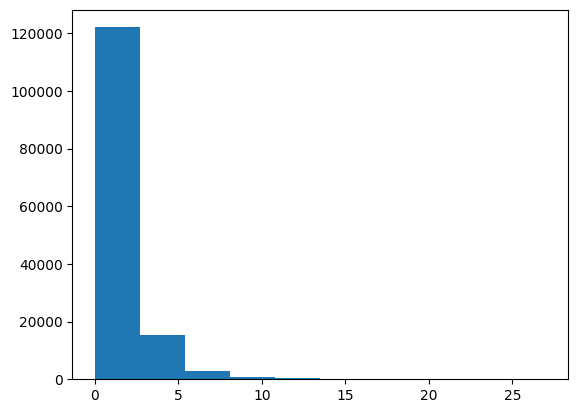

In [22]:
import matplotlib.pyplot as plt
plt.hist(x)

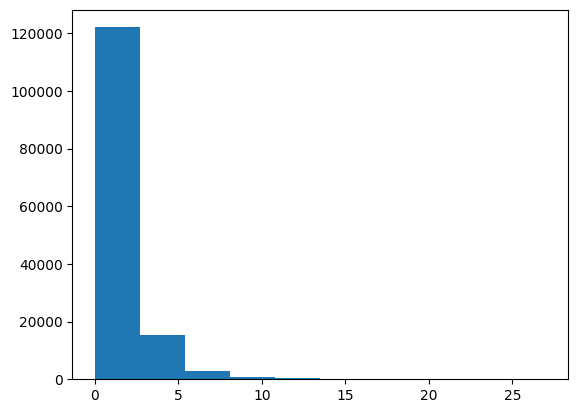

In [23]:
plt.hist(x.dropna());

(array([1.24588e+05, 1.26750e+04, 2.49100e+03, 8.77000e+02, 4.19000e+02,
        2.77000e+02, 1.82000e+02, 1.06000e+02, 6.40000e+01, 2.00000e+01,
        1.00000e+01, 3.00000e+00]),
 array([  0.  ,  10.75,  21.5 ,  32.25,  43.  ,  53.75,  64.5 ,  75.25,
         86.  ,  96.75, 107.5 , 118.25, 129.  ]),
 <BarContainer object of 12 artists>)

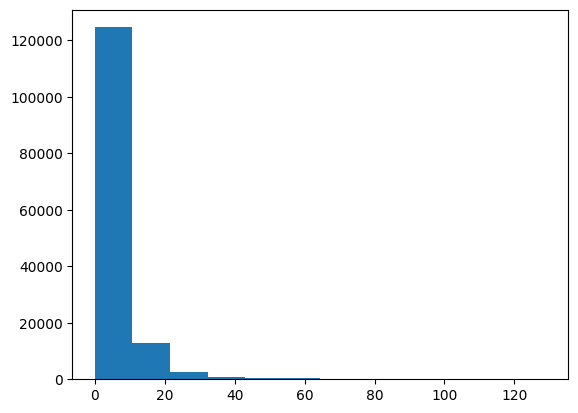

In [24]:
plt.hist(pd.Series(data['sys_mod_count']).dropna(), bins=12)

In [100]:
# This step is where I'm choosing the features / columns I'd like to start looking at.  I chose these features, but we can definitely choose more/less from the original dataset

df_unique = df[['number', 'made_sla', 'category', 'subcategory', 'location', 'opened_by', 'resolved_by','sys_mod_count']]
df_unique

,number,made_sla,category,subcategory,location,opened_by,resolved_by,sys_mod_count
0,INC0000045,True,Category 55,Subcategory 170,Location 143,Opened by 8,Resolved by 149,0
1,INC0000045,True,Category 55,Subcategory 170,Location 143,Opened by 8,Resolved by 149,2
2,INC0000045,True,Category 55,Subcategory 170,Location 143,Opened by 8,Resolved by 149,3
3,INC0000045,True,Category 55,Subcategory 170,Location 143,Opened by 8,Resolved by 149,4
4,INC0000047,True,Category 40,Subcategory 215,Location 165,Opened by 397,Resolved by 81,0
...,...,...,...,...,...,...,...,...
141707,INC0120835,True,Category 42,Subcategory 223,Location 204,Opened by 12,Resolved by 9,4
141708,INC0121064,True,Category 42,Subcategory 223,Location 204,Opened by 12,Resolved by 9,0
141709,INC0121064,True,Category 42,Subcategory 223,Location 204,Opened by 12,Resolved by 9,1
141710,INC0121064,True,Category 42,Subcategory 223,Location 204,Opened by 12,Resolved by 9,2


In [101]:
# I dropped any duplicate rows, as you can see in the original dataset, there are a number of rows for each unique incident (e.g. INC...00045 has 4 records, each for a different status update)
    # Those Multiples correspond to the various updates and I'm just looking for the unique incidents.
    # Records should go from approx 141,712 with multiples by incident to 36,247 unique incidents


max_indices = df_unique.groupby('number')['sys_mod_count'].idxmax()
df_unique = df_unique.loc[max_indices].reset_index(drop=True)

#df_unique = df_unique.drop_duplicates()
df_unique

,number,made_sla,category,subcategory,location,opened_by,resolved_by,sys_mod_count
0,INC0000045,True,Category 55,Subcategory 170,Location 143,Opened by 8,Resolved by 149,4
1,INC0000047,True,Category 40,Subcategory 215,Location 165,Opened by 397,Resolved by 81,8
2,INC0000057,True,Category 20,Subcategory 125,Location 204,Opened by 8,Resolved by 5,6
3,INC0000060,True,Category 9,Subcategory 97,Location 204,Opened by 180,Resolved by 113,3
4,INC0000062,False,Category 53,Subcategory 168,Location 93,Opened by 180,Resolved by 62,7
...,...,...,...,...,...,...,...,...
24913,INC0120304,True,Category 52,Subcategory 177,Location 188,Opened by 8,Resolved by 5,2
24914,INC0120319,True,Category 50,Subcategory 10,Location 246,Opened by 508,?,1
24915,INC0120495,True,Category 59,Subcategory 210,Location 135,Opened by 14,?,5
24916,INC0120835,True,Category 42,Subcategory 223,Location 204,Opened by 12,Resolved by 9,4


In [50]:
# Removing the Incident # column because this did not work well when I tried modeling and should not have any bearing on the result

df_unique = df_unique[['made_sla', 'category', 'subcategory', 'location', 'opened_by', 'resolved_by']]
df_unique

,made_sla,category,subcategory,location,opened_by,resolved_by
0,True,Category 55,Subcategory 170,Location 143,Opened by 8,Resolved by 149
1,True,Category 55,Subcategory 170,Location 143,Opened by 8,Resolved by 149
2,True,Category 55,Subcategory 170,Location 143,Opened by 8,Resolved by 149
3,True,Category 55,Subcategory 170,Location 143,Opened by 8,Resolved by 149
4,True,Category 40,Subcategory 215,Location 165,Opened by 397,Resolved by 81
...,...,...,...,...,...,...
141707,True,Category 42,Subcategory 223,Location 204,Opened by 12,Resolved by 9
141708,True,Category 42,Subcategory 223,Location 204,Opened by 12,Resolved by 9
141709,True,Category 42,Subcategory 223,Location 204,Opened by 12,Resolved by 9
141710,True,Category 42,Subcategory 223,Location 204,Opened by 12,Resolved by 9


In [102]:
# You can see the row count in the above, but here's a line of code to check the shape of data (rows, features)

df_unique.shape

(24918, 8)

In [124]:
# Here we are splitting the dataset into two parts.
    # First part is 90% of the dataset which will be used to train, test, evaluate ("Seen Data")
    # and the second part is 10% which we will withhold from any training to use to fine-tune the model ("Unseen Data")

    # i.e. this step should show us that our df_seen will be 90% of 36,247 = 32,622 and df_unseen should be 10% of 36,247 = 3,625

df_seen = df_unique.sample(frac=0.9, random_state=786)
df_unseen = df_unique.drop(df_seen.index)

df_seen.reset_index(drop=True, inplace=True)
df_unseen.reset_index(drop=True, inplace=True)

print('Data for Modeling: ' + str(df_seen.shape))
print('Unseen Data For Predictions: ' + str(df_unseen.shape))

Data for Modeling: (22426, 8)
Unseen Data For Predictions: (2492, 8)


In [104]:
# Install & Import Pycaret
#!pip install pycaret[full]

import pycaret


In [105]:
# I started following / using this tutorial to help guide me through the modeling : https://towardsdatascience.com/introduction-to-regression-in-python-with-pycaret-d6150b540fc4

    # Note that this is not 100% applicable to our dataset above due to it being a classification, rather than regression, but it still helps frame up how we solve
    # Steps 1-6 from the tutorial are not really applicable / are done in the above lines, so I've skipped.
gpu_available

True

In [106]:
# Step 7: Setting up the model / experiment
# set use_gpu to true if a GPU is availabe, see start of notebook.

from pycaret.classification import *
s = setup(df_unique, target = 'made_sla', session_id = 123, use_gpu=gpu_available)

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Number of positive: 1, number of negative: 1
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Warning] Using sparse features with CUDA is currently not supported.
[LightGBM] [Info] Number of positive: 1, number of negative: 1
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset migh

,Description,Value
0,Session id,123
1,Target,made_sla
2,Target type,Binary
3,Original data shape,"(24918, 8)"
4,Transformed data shape,"(24918, 8)"
5,Transformed train set shape,"(17442, 8)"
6,Transformed test set shape,"(7476, 8)"
7,Numeric features,1
8,Categorical features,6
9,Preprocess,True


[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Number of positive: 1, number of negative: 1
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Warning] Using sparse features with CUDA is currently not supported.
[LightGBM] [Info] Number of positive: 1, number of negative: 1
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset migh

In [107]:
# import ClassificationExperiment and init the class
from pycaret.classification import ClassificationExperiment
exp = ClassificationExperiment()

In [108]:
# check the type of exp
type(exp)

pycaret.classification.oop.ClassificationExperiment

In [109]:
# init setup on exp
exp.setup(df_unique, target = 'made_sla', session_id = 123)

,Description,Value
0,Session id,123
1,Target,made_sla
2,Target type,Binary
3,Original data shape,"(24918, 8)"
4,Transformed data shape,"(24918, 8)"
5,Transformed train set shape,"(17442, 8)"
6,Transformed test set shape,"(7476, 8)"
7,Numeric features,1
8,Categorical features,6
9,Preprocess,True


In [110]:
# Step 8: compare baseline models

best = compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
knn,K Neighbors Classifier,0.8169,0.8498,0.9412,0.8037,0.8670,0.5789,0.5978,0.4060
lr,Logistic Regression,0.7790,0.8946,0.9830,0.7479,0.8495,0.4614,0.5279,0.4500
svm,SVM - Linear Kernel,0.7317,0.0000,0.9624,0.7251,0.8219,0.3216,0.3971,0.3140
et,Extra Trees Classifier,0.6407,0.6606,0.9998,0.6384,0.7792,0.0225,0.0980,0.5630
nb,Naive Bayes,0.6342,0.5000,1.0000,0.6342,0.7762,0.0000,0.0000,0.2580
dt,Decision Tree Classifier,0.6342,0.5000,1.0000,0.6342,0.7762,0.0000,0.0000,0.2540
ridge,Ridge Classifier,0.6342,0.0000,1.0000,0.6342,0.7762,0.0000,0.0000,0.3290
rf,Random Forest Classifier,0.6342,0.7937,1.0000,0.6342,0.7762,0.0000,0.0000,0.6590
qda,Quadratic Discriminant Analysis,0.6342,0.5000,1.0000,0.6342,0.7762,0.0000,0.0000,0.2630
ada,Ada Boost Classifier,0.6342,0.5000,1.0000,0.6342,0.7762,0.0000,0.0000,0.2600


Processing:   0%|          | 0/69 [00:00<?, ?it/s]

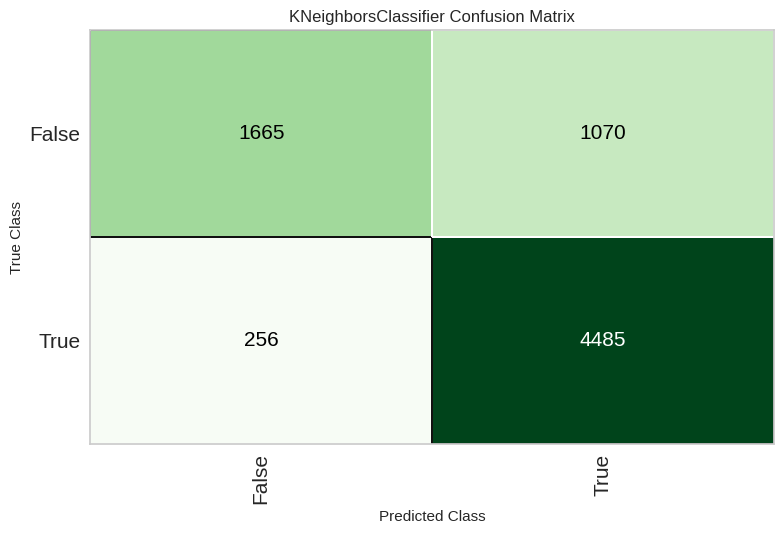

In [111]:
# plot confusion matrix
plot_model(best, plot = 'confusion_matrix')

ANALYZE MODEL

In [112]:
# plot feature importance
#plot_model(best, plot = 'feature')

TypeError: ignored

In [113]:
evaluate_model(best)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

Prediction

In [114]:
# predict on test set
holdout_pred = predict_model(best)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,K Neighbors Classifier,0.8226,0.8513,0.9460,0.8074,0.8712,0.5921,0.6115


In [116]:
# show predictions df
holdout_pred.head(10)

,number,category,subcategory,location,opened_by,resolved_by,sys_mod_count,made_sla,prediction_label,prediction_score
7535,INC0011523,Category 46,Subcategory 191,Location 204,Opened by 20,Resolved by 69,3,True,1,1.0
12222,INC0017950,Category 26,Subcategory 175,Location 143,Opened by 24,Resolved by 15,2,True,1,1.0
5658,INC0008777,Category 13,Subcategory 302,Location 93,Opened by 40,Resolved by 196,8,True,1,1.0
19207,INC0027138,Category 57,Subcategory 184,Location 143,Opened by 8,Resolved by 150,7,False,1,1.0
22235,INC0031161,Category 26,Subcategory 175,Location 93,Opened by 256,Resolved by 203,5,True,1,1.0
2744,INC0004258,Category 45,Subcategory 200,Location 93,Opened by 24,Resolved by 166,4,False,1,0.8
8131,INC0012304,Category 46,Subcategory 259,Location 93,Opened by 17,Resolved by 159,17,False,0,1.0
14030,INC0020440,Category 32,Subcategory 300,Location 143,Opened by 55,Resolved by 177,11,False,1,0.8
8289,INC0012510,Category 46,Subcategory 223,Location 188,Opened by 24,Resolved by 69,2,True,1,1.0
6811,INC0010425,Category 32,Subcategory 300,Location 113,Opened by 17,Resolved by 66,13,False,0,1.0


In [117]:
# Step 10 - Tune Model: Now comes the tuning of the model I picked

tuned_model = tune_model(best)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8372,0.9007,0.9368,0.8289,0.8796,0.6315,0.6429
1,0.8298,0.8816,0.9250,0.8271,0.8733,0.6164,0.6254
2,0.8205,0.8863,0.9250,0.8164,0.8673,0.5934,0.6045
3,0.8377,0.8997,0.9394,0.8279,0.8801,0.6321,0.6443
4,0.8245,0.9003,0.9358,0.8150,0.8712,0.6001,0.6144
5,0.8280,0.9056,0.9358,0.8188,0.8734,0.6088,0.6221
6,0.8469,0.9079,0.9430,0.8364,0.8865,0.6539,0.6651
7,0.8251,0.9014,0.9295,0.8191,0.8708,0.6035,0.6151
8,0.8280,0.8986,0.9358,0.8188,0.8734,0.6088,0.6221


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits


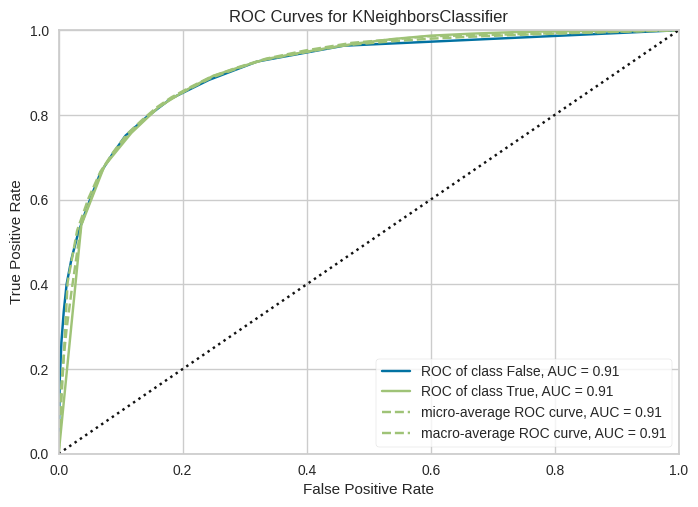

In [118]:
# Step 11a - Plot Model: Plotting the model to see how accurate

plot_model(tuned_model)

In [119]:
# Step 11b - Evaluate / Plot Model: Evaluating the model, I looked at the Feature Importance to try and get a better idea of which features were the most important

evaluate_model(tuned_model)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

In [120]:
# Step 12 - Preict on Test / Hold-out Model (NOT to be confused with unseen data)

holdout_pred = predict_model(tuned_model);

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,K Neighbors Classifier,0.8341,0.9059,0.9325,0.8277,0.8770,0.6251,0.6357


In [121]:
# Step 13 - Finalize Model for Deployment

final_model = finalize_model(tuned_model)

print(final_model)

Pipeline(memory=Memory(location=None),
         steps=[('numerical_imputer',
                 TransformerWrapper(exclude=None, include=['sys_mod_count'],
                                    transformer=SimpleImputer(add_indicator=False,
                                                              copy=True,
                                                              fill_value=None,
                                                              keep_empty_features=False,
                                                              missing_values=nan,
                                                              strategy='mean',
                                                              verbose='deprecated'))),
                ('categorical_imputer',
                 TransformerWrapper(exclude=None,
                                    include=['numb...
                                                                    'location',
                                                  

In [122]:
predict_model(final_model);

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,K Neighbors Classifier,0.8442,0.9282,0.9401,0.8350,0.8844,0.6479,0.6587


In [125]:
# Step 14: Predict on unseen Data

unseen_predictions = predict_model(final_model, data=df_unseen)
unseen_predictions.head()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,K Neighbors Classifier,0.9807,0.9984,0.9891,0.9803,0.9847,0.9588,0.9588


,number,category,subcategory,location,opened_by,resolved_by,sys_mod_count,made_sla,prediction_label,prediction_score
0,INC0000047,Category 40,Subcategory 215,Location 165,Opened by 397,Resolved by 81,8,True,0,0.6250
1,INC0000063,Category 20,Subcategory 125,Location 93,Opened by 180,Resolved by 62,7,True,1,0.9375
2,INC0000073,Category 53,Subcategory 271,Location 42,Opened by 40,Resolved by 208,6,True,1,0.9375
3,INC0000113,Category 55,Subcategory 23,Location 204,Opened by 24,Resolved by 206,4,True,1,1.0000
4,INC0000129,Category 23,Subcategory 75,Location 135,Opened by 180,Resolved by 231,17,False,0,0.9375


In [127]:
# Step 15 - Saving the Model

save_model(final_model, 'Final Logistic Regression Model 14Oct2023')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=None),
          steps=[('numerical_imputer',
                  TransformerWrapper(exclude=None, include=['sys_mod_count'],
                                     transformer=SimpleImputer(add_indicator=False,
                                                               copy=True,
                                                               fill_value=None,
                                                               keep_empty_features=False,
                                                               missing_values=nan,
                                                               strategy='mean',
                                                               verbose='deprecated'))),
                 ('categorical_imputer',
                  TransformerWrapper(exclude=None,
                                     include=['numb...
                                                                     'location',
                                    